In [1]:
# ライブラリのimport

# NumPy用ライブラリ
import numpy as np

# Matplotlib中のpyplotライブラリのインポート
import matplotlib.pyplot as plt

# matplotlib日本語化対応ライブラリのインポート
import japanize_matplotlib

# pandas用ライブラリ
import pandas as pd

# データフレーム表示用関数
from IPython.display import display

# seaborn
import seaborn as sns

# 表示オプション調整
# NumPy表示形式の設定
np.set_printoptions(precision=3, floatmode="fixed")
# グラフのデフォルトフォント指定
plt.rcParams["font.size"] = 14
# サイズ設定
plt.rcParams["figure.figsize"] = (6, 6)
# 方眼表示ON
plt.rcParams["axes.grid"] = True
# データフレームでの表示精度
pd.options.display.float_format = "{:.3f}".format
# データフレームですべての項目を表示
pd.set_option("display.max_columns", None)

In [2]:
import pymc as pm
import arviz as az

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on ArViz v{az.__version__}")

Running on PyMC v5.25.1
Running on ArViz v0.22.0


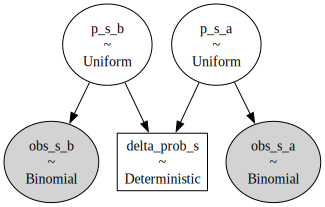

In [3]:
# ベイズモデルの「器」を明示的に作っておく。
# ただし、この直後に `with pm.Model() as model_s:` として新しい Model を作り直しているため、
# ここでの model_s = pm.Model() は理論的にも実装的にも冗長になる（後者が有効なモデルになる）。
# 教材としては「Model コンテキストで定義された確率変数だけが同じ確率グラフに乗る」ことを示す例とも読める。
model_s = pm.Model()

# `with pm.Model() as model_s:` に入った瞬間、このブロック内で定義される確率変数が
# すべて同一のベイズモデル（確率グラフ）に属する。
# つまり、以下は「2つの独立な二項観測の成功確率をそれぞれ推定し、その差の事後も得る」
# という1階層ベイズモデルの定義になっている。
with pm.Model() as model_s:
    # 事前分布として一様分布を採用。
    # p_s_a, p_s_b はそれぞれ「A/B の成功確率（ヒット率）」に対応する未知パラメータ。
    # Uniform(0,1) は Beta(1,1) と等価で、確率パラメータに対する最も非情報的な共役事前の一つ。
    # 事前知識をほとんど置かず、観測データから確率を学習させたいときの標準設定である。
    p_s_a = pm.Uniform("p_s_a", lower=0.0, upper=1.0)
    p_s_b = pm.Uniform("p_s_b", lower=0.0, upper=1.0)

    # 二項分布で確率モデル（尤度）を定義。
    # obs_s_a は「A の 40 回の試行で成功（ヒット）2回」という観測を表す。
    # obs_s_b は「B の 25 回の試行で成功（ヒット）2回」という観測を表す。
    #
    # 理論的には
    #   obs_s_a | p_s_a ~ Binomial(n=40, p=p_s_a)
    #   obs_s_b | p_s_b ~ Binomial(n=25, p=p_s_b)
    # という条件付き分布を置いたことに相当する。
    #
    # ここで observed に成功回数（ヒット数）を与えることで、
    # PyMC はこの尤度を用いて p_s_a, p_s_b の事後分布
    #   p(p_s_a, p_s_b | data)
    # を MCMC により推定する。
    # n:表示数, observed:ヒット数 という対応づけは二項モデルの自然な解釈である。
    obs_s_a = pm.Binomial("obs_s_a", p=p_s_a, n=40, observed=2)
    obs_s_b = pm.Binomial("obs_s_b", p=p_s_b, n=25, observed=2)

    # 新たな確率変数として、2つの確率パラメータの「差」を決定論的に定義する。
    # delta_prob_s = p_s_b - p_s_a は確率変数そのものではなく、
    # 事後サンプル (p_s_a^{(s)}, p_s_b^{(s)}) ごとに計算される派生量である。
    #
    # 理論的には「比較したい量の事後分布」を直接得るための典型的な書き方で、
    #   delta_prob_s | data
    # の分布は
    #   p(delta | data) = ∬ δ = p_s_b - p_s_a を満たす下で
    #                    p(p_s_a, p_s_b | data) を写像したもの
    # と解釈できる。
    #
    # これにより
    #   P(delta_prob_s > 0 | data)
    # のような「B の方が A より良い確率」が、そのままモンテカルロ近似で評価できる。
    delta_prob_s = pm.Deterministic("delta_prob_s", p_s_b - p_s_a)

# 確率モデル構造（確率グラフ）を可視化。
# ここで表示される DAG は
#   p_s_a → obs_s_a
#   p_s_b → obs_s_b
#   (p_s_a, p_s_b) → delta_prob_s
# という依存関係を示すはずで、理論式と実装の対応確認に役立つ。
g = pm.model_to_graphviz(model_s)
display(g)

In [4]:
with model_s:
    idata_s = pm.sample(random_seed=42, target_accept=0.99)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_s_a, p_s_b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


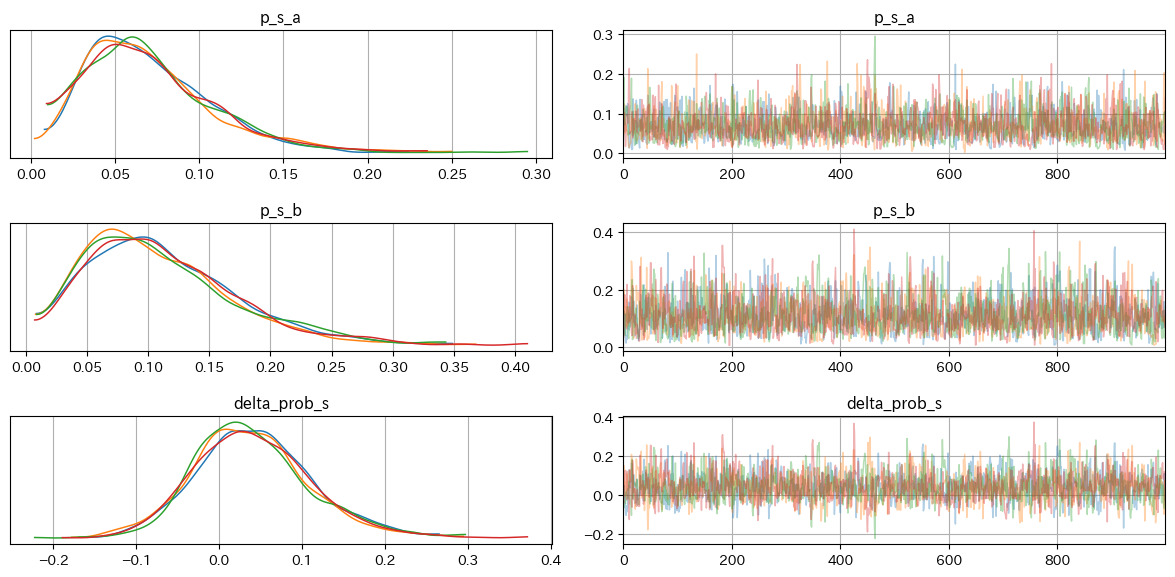

In [5]:
az.plot_trace(idata_s, compact=False)
plt.tight_layout()

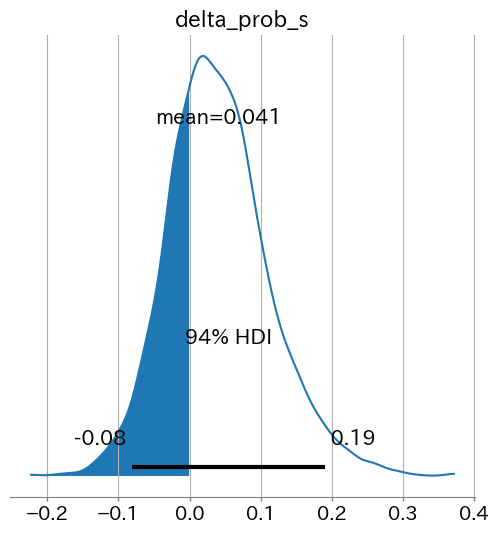

In [6]:
ax = az.plot_posterior(idata_s, var_names=["delta_prob_s"])
xx, yy = ax.get_lines()[0].get_data()
ax.fill_between(xx[xx < 0], yy[xx < 0])

In [7]:
# サンプリング結果から　delta_probの値を抽出
delta_prob_s = idata_s["posterior"].data_vars["delta_prob_s"]
delta_prob_s_values = delta_prob_s.values.reshape(-1)

# delta_probの値がマイナスであった件数
n1_s = (delta_prob_s_values < 0).sum()

# 全体サンプル数
n_s = len(delta_prob_s_values)

# 比率計算
n1_rate_s = n1_s / n_s
print(f"鈴木さんケース　画面Aの方がクリック率が高い確率: {n1_rate_s*100:.02f}%")

鈴木さんケース　画面Aの方がクリック率が高い確率: 29.00%


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_y_a, p_y_b]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


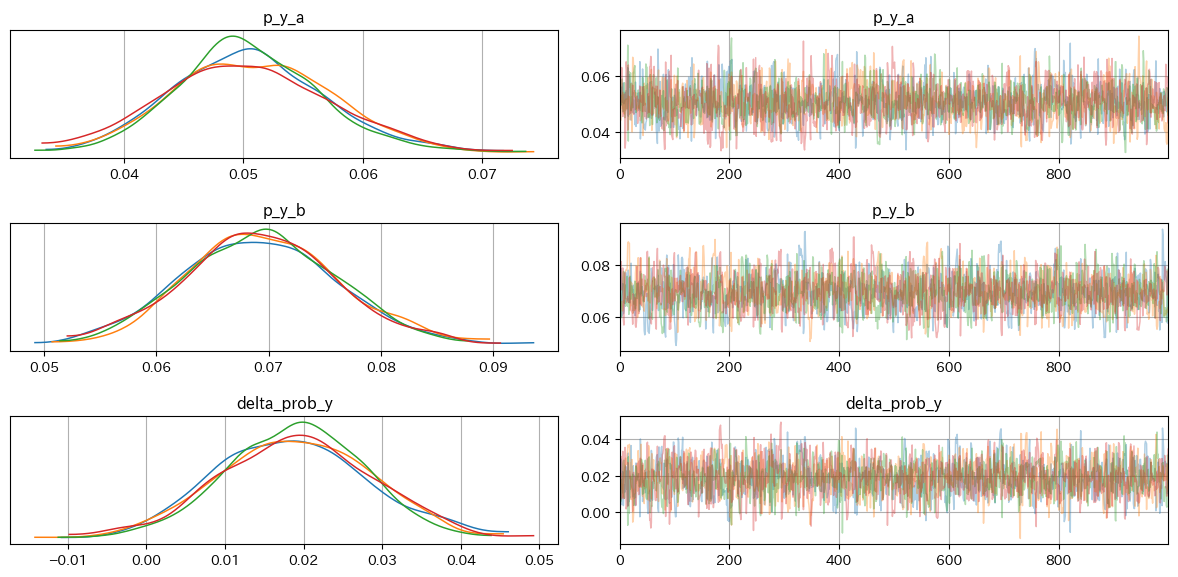

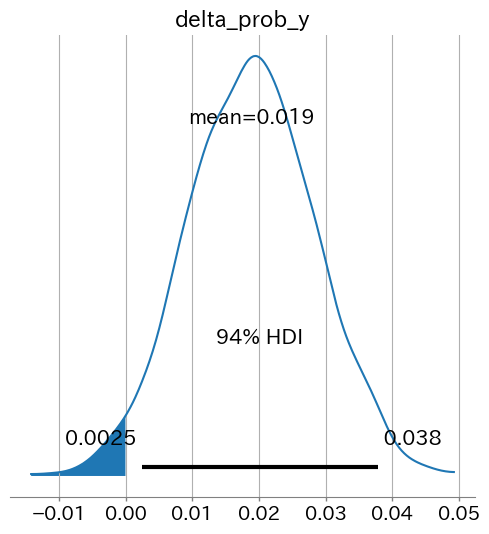

In [8]:
model_y = pm.Model()

with pm.Model() as model_y:
    # 事前分布として一様分布を採用
    p_y_a = pm.Uniform("p_y_a", lower=0.0, upper=1.0)
    p_y_b = pm.Uniform("p_y_b", lower=0.0, upper=1.0)

    # 二項分布で確率モデルを定義
    # n:表示数　observed:ヒット数　とすればよい
    obs_y_a = pm.Binomial("obs_y_a", p=p_y_a, n=1200, observed=60)
    obs_y_b = pm.Binomial("obs_y_b", p=p_y_b, n=1600, observed=110)

    # 新たな確率変数として二つの確率変数の差を定義
    delta_prob_y = pm.Deterministic("delta_prob_y", p_y_b - p_y_a)

# サンプリング
with model_y:
    idata_y = pm.sample(random_seed=42, target_accept=0.99)

# traceの確認
az.plot_trace(idata_y, compact=False)
plt.tight_layout()
plt.show()

# delta_prob_yの分布を可視化
ax = az.plot_posterior(idata_y, var_names=["delta_prob_y"])
xx, yy = ax.get_lines()[0].get_data()
ax.fill_between(xx[xx < 0], yy[xx < 0])

In [9]:
# サンプリング結果から　delta_probの値を抽出
delta_prob_y = idata_y["posterior"].data_vars["delta_prob_y"]
delta_prob_y_values = delta_prob_y.values.reshape(-1)

# delta_probの値がマイナスであった件数
n1_y = (delta_prob_y_values < 0).sum()

# 全体サンプル数
n_y = len(delta_prob_y_values)

# 比率計算
n1_rate_y = n1_y / n_y

print(f"山田さんケース　画面Aの方がクリック率が高い確率: {n1_rate_y*100:.02f}%")

山田さんケース　画面Aの方がクリック率が高い確率: 2.43%
